In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import pywt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import tensorflow as tf
from keras.optimizers import SGD, Adam
from tensorflow import keras
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError

In [3]:
#doc dataset
df = pd.read_csv("ALL.csv")
df.head()
print(df.isnull().sum())
#xử lí giá trị âm
colum_press = ['BO1016_Pressure(m)', 'BO1017_Pressure(m)', 'BO1021_Pressure', 'BO1022_Pressure(m)', 'BO1029_Pressure(m)', 'NB1019_Pressure', 'TD1029_Pressure', 'TD1043_Press(m)']
df[colum_press] = df[colum_press].apply(lambda x:x+5)
df.describe()


Date_time             0
BO1013_FLOW1          0
BO1016_Pressure(m)    0
BO1017_Pressure(m)    0
BO1021_FLOW1)         0
BO1021_Pressure       0
BO1022_flow1          0
BO1022_Pressure(m)    0
BO1017_FLOW1          0
BO1029_FLOW1          0
BO1029_Pressure(m)    0
NB1013_FLOW1          0
NB1017_FLOW1          0
NB1017_Pressure       0
NB1019_FLOW1          0
NB1019_Pressure       0
NB1020_FLOW1          0
NB1021_FLOW1          0
NB1022_FLOW1          0
TD1029_flow1          0
TD1029_Pressure       0
TD1043_FLOW1          0
TD1043_Press(m)       0
NMNBOOTM1_FLOW1       0
BOO_TM2_Pressure      0
dtype: int64
                BO1013_FLOW1  BO1016_Pressure(m)  BO1017_Pressure(m)  \
Date_time                                                              
9/15/2023 0:00      0.463406            0.616835            0.374450   
9/15/2023 0:15      0.450752            0.622623            0.389156   
9/15/2023 0:30      0.439808            0.627547            0.402763   
9/15/2023 0:45      0.43023

In [ ]:
#tách tập trạng thái và tập điều khiển
df.set_index("Date_time", inplace=True) #set index
control = df["BOO_TM2_Pressure"]
state = df
#state_ = df.drop([ "BOO_TM2_Pressure"], axis = 1)
features = df.columns
scaler =MMS() #scale data
state_scaler = scaler.fit_transform(state[features])
state = pd.DataFrame(columns=features, data=state_scaler, index = df["BOO_TM2_Pressure"].index)
control_scaler = scaler.fit_transform(control.values.reshape(-1, 1)) 
control = pd.DataFrame(columns=["BOO_TM2_Pressure"], data=control_scaler, index = df.index)
# check
print(state.head())
print(control.head())
# tạo biến thử
dense_act = ['ReLU', 'elu', 'tanh', 'sigmoid', 'selu'] 
recur_act = ['ReLU', 'elu', 'tanh', 'sigmoid', 'selu']
epoch = 100
# epoch = [100, 256, 500]
learning_r = 0.001
# learning_r = [0.0005, 0.001, 0.002] 
ls = 'mae'
# ls = ['mae', 'mse']
'''opt1 = SGD()
opt2 = Adam()'''
print('yes')
kind = []
sc = []

In [5]:
'''LSTM2 X = state = state+control ; y = control, window = 5'''
# def state_X_y(df, window_size):
#     X = []
#     y = []
#     for i in range(len(df_x) - window_size):
#         row = [r for r in df_x[i:i+window_size]]
#         X.append(row)
#         label = df_y[i+window_size][0]
#         y.append(label)
#     return np.array(X), np.array(y)
# X_state , y_state = state_X_y(state, 5)
# X_state.shape , y_state.shape
# X_state[0]
#  Tạo các tập X và Y
X = []
Y = []
# Loop qua các hàng của dataframe để lấy các cửa sổ thời gian t-5 đến t và giá trị tại t+1 cho Y
for i in range(288, len(df) - 1):
    X.append(state.iloc[i-288:i].values)  # Lấy cửa sổ thời gian t-5 đến < t
    Y.append(control.iloc[i])  # Lấy giá trị t của cột cuối cùng

X = np.array(X)
Y = np.array(Y)
X[0],Y[0]


(array([[0.46340629, 0.61683516, 0.37445049, ..., 0.52747253, 0.58980589,
         0.13815261],
        [0.45075239, 0.62262323, 0.38915637, ..., 0.52747253, 0.54611657,
         0.11325301],
        [0.43980848, 0.62754701, 0.40276324, ..., 0.52747253, 0.53398064,
         0.11325301],
        ...,
        [0.54753762, 0.65538736, 0.42751727, ..., 0.59340659, 0.62621359,
         0.13815261],
        [0.5369357 , 0.66245875, 0.4432175 , ..., 0.59340659, 0.62135922,
         0.13815261],
        [0.50444596, 0.65046357, 0.42992464, ..., 0.59340659, 0.61407767,
         0.13815261]]),
 array([0.13815261]))

In [5]:
X_state_tr, X_state_te, y_state_tr, y_state_te = train_test_split(X, Y, test_size = 0.25, random_state = 25)
X_state_tr.shape , y_state_tr.shape


((7631, 288, 24), (7631, 1))

In [5]:
best_score = float('inf')
best_params = None
best_model = None
for i in dense_act:
    for j in recur_act:
        
        opt = Adam(learning_rate= learning_r)
        model3 = Sequential([
        tf.keras.layers.LSTM(64, recurrent_activation = j, input_shape = [5, 24]),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation = i),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(16, activation = i),
        tf.keras.layers.Dense(8, activation = i),
        tf.keras.layers.Dense(1)
                         ])
        model3.compile(optimizer = opt, loss = ls, )
        apply3 = model3.fit(X_state_tr, y_state_tr, batch_size = 1024, epochs = epoch, validation_split = 0.2)
        name = "model: "+ "dense_act3 "+ i+ " recur_act3 "+ j
        score = model3.evaluate(X_state_te, y_state_te)
        kind.append(name)
        kind.append(score)
        sc.append(score)
        if score < best_score:
            best_score = score
            best_params = (i, j)
            best_model = model3
print("Best parameters found:")
print(f"dense_act: {best_params[0]}, recur_act: {best_params[1]}")
print("Best score:", best_score)

Epoch 1/100
7/7 [==============================] - 3s 79ms/step - loss: 0.3075 - val_loss: 0.2990
Epoch 2/100
7/7 [==============================] - 0s 28ms/step - loss: 0.2881 - val_loss: 0.2802
Epoch 3/100
7/7 [==============================] - 0s 29ms/step - loss: 0.2664 - val_loss: 0.2458
Epoch 4/100
7/7 [==============================] - 0s 28ms/step - loss: 0.2272 - val_loss: 0.1869
Epoch 5/100
7/7 [==============================] - 0s 29ms/step - loss: 0.1611 - val_loss: 0.1348
Epoch 6/100
7/7 [==============================] - 0s 28ms/step - loss: 0.1434 - val_loss: 0.1397
Epoch 7/100
7/7 [==============================] - 0s 27ms/step - loss: 0.1359 - val_loss: 0.1296
Epoch 8/100
7/7 [==============================] - 0s 28ms/step - loss: 0.1282 - val_loss: 0.1183
Epoch 9/100
7/7 [==============================] - 0s 28ms/step - loss: 0.1164 - val_loss: 0.1033
Epoch 10/100
7/7 [==============================] - 0s 26ms/step - loss: 0.0973 - val_loss: 0.0796
Epoch 11/100
7/7 [=

Epoch 84/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0237 - val_loss: 0.0383
Epoch 85/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0236 - val_loss: 0.0417
Epoch 86/100
7/7 [==============================] - 0s 30ms/step - loss: 0.0234 - val_loss: 0.0350
Epoch 87/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0237 - val_loss: 0.0431
Epoch 88/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0240 - val_loss: 0.0353
Epoch 89/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0230 - val_loss: 0.0402
Epoch 90/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0231 - val_loss: 0.0366
Epoch 91/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0235 - val_loss: 0.0360
Epoch 92/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0227 - val_loss: 0.0406
Epoch 93/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0231 - val_loss: 0.0337
Epoch 94/1

7/7 [==============================] - 0s 29ms/step - loss: 0.0265 - val_loss: 0.0261
Epoch 49/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0257 - val_loss: 0.0294
Epoch 50/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0254 - val_loss: 0.0293
Epoch 51/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0249 - val_loss: 0.0281
Epoch 52/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0254 - val_loss: 0.0255
Epoch 53/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0250 - val_loss: 0.0349
Epoch 54/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0253 - val_loss: 0.0334
Epoch 55/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0262 - val_loss: 0.0261
Epoch 56/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0248 - val_loss: 0.0378
Epoch 57/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0252 - val_loss: 0.0211
Epoch 58/100
7/7 [=====

7/7 [==============================] - 0s 31ms/step - loss: 0.0448 - val_loss: 0.0349
Epoch 13/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0432 - val_loss: 0.0431
Epoch 14/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0417 - val_loss: 0.0405
Epoch 15/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0399 - val_loss: 0.0305
Epoch 16/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0396 - val_loss: 0.0381
Epoch 17/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0386 - val_loss: 0.0282
Epoch 18/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0366 - val_loss: 0.0314
Epoch 19/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0364 - val_loss: 0.0258
Epoch 20/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0354 - val_loss: 0.0396
Epoch 21/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0355 - val_loss: 0.0253
Epoch 22/100
7/7 [=====

Epoch 95/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0220 - val_loss: 0.0260
Epoch 96/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0216 - val_loss: 0.0300
Epoch 97/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0217 - val_loss: 0.0238
Epoch 98/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0223 - val_loss: 0.0250
Epoch 99/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0222 - val_loss: 0.0325
Epoch 100/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0223
Epoch 1/100
7/7 [==============================] - 2s 72ms/step - loss: 0.2174 - val_loss: 0.1463
Epoch 2/100
7/7 [==============================] - 0s 28ms/step - loss: 0.1486 - val_loss: 0.1199
Epoch 3/100
7/7 [==============================] - 0s 32ms/step - loss: 0.1214 - val_loss: 0.1177
Epoch 4/100
7/7 [==============================] - 0s 32ms/step - loss: 0.1148 - val_loss: 0.1053
Epoch 5/100
7/7 [==============

7/7 [==============================] - 0s 31ms/step - loss: 0.0238 - val_loss: 0.0228
Epoch 60/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0247 - val_loss: 0.0198
Epoch 61/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0239 - val_loss: 0.0193
Epoch 62/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0235 - val_loss: 0.0189
Epoch 63/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0239 - val_loss: 0.0193
Epoch 64/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0240 - val_loss: 0.0190
Epoch 65/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0237 - val_loss: 0.0201
Epoch 66/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0247 - val_loss: 0.0197
Epoch 67/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0242 - val_loss: 0.0188
Epoch 68/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0231 - val_loss: 0.0189
Epoch 69/100
7/7 [=====

7/7 [==============================] - 0s 36ms/step - loss: 0.0467 - val_loss: 0.0390
Epoch 24/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0460 - val_loss: 0.0377
Epoch 25/100
7/7 [==============================] - 0s 35ms/step - loss: 0.0451 - val_loss: 0.0371
Epoch 26/100
7/7 [==============================] - 0s 44ms/step - loss: 0.0438 - val_loss: 0.0382
Epoch 27/100
7/7 [==============================] - 0s 53ms/step - loss: 0.0444 - val_loss: 0.0359
Epoch 28/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0429 - val_loss: 0.0380
Epoch 29/100
7/7 [==============================] - 0s 49ms/step - loss: 0.0432 - val_loss: 0.0344
Epoch 30/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0422 - val_loss: 0.0358
Epoch 31/100
7/7 [==============================] - 0s 39ms/step - loss: 0.0405 - val_loss: 0.0330
Epoch 32/100
7/7 [==============================] - 0s 41ms/step - loss: 0.0400 - val_loss: 0.0347
Epoch 33/100
7/7 [=====

Epoch 88/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0227 - val_loss: 0.0206
Epoch 89/100
7/7 [==============================] - 0s 34ms/step - loss: 0.0234 - val_loss: 0.0218
Epoch 90/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0227 - val_loss: 0.0186
Epoch 91/100
7/7 [==============================] - 0s 35ms/step - loss: 0.0220 - val_loss: 0.0185
Epoch 92/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0216 - val_loss: 0.0186
Epoch 93/100
7/7 [==============================] - 0s 44ms/step - loss: 0.0220 - val_loss: 0.0200
Epoch 94/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0222 - val_loss: 0.0185
Epoch 95/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0221 - val_loss: 0.0206
Epoch 96/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0231 - val_loss: 0.0193
Epoch 97/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0221 - val_loss: 0.0188
Epoch 98/1

7/7 [==============================] - 0s 35ms/step - loss: 0.0253 - val_loss: 0.0226
Epoch 53/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0254 - val_loss: 0.0204
Epoch 54/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0249 - val_loss: 0.0210
Epoch 55/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0244 - val_loss: 0.0215
Epoch 56/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0250 - val_loss: 0.0204
Epoch 57/100
7/7 [==============================] - 0s 30ms/step - loss: 0.0247 - val_loss: 0.0209
Epoch 58/100
7/7 [==============================] - 0s 28ms/step - loss: 0.0240 - val_loss: 0.0191
Epoch 59/100
7/7 [==============================] - 0s 34ms/step - loss: 0.0233 - val_loss: 0.0193
Epoch 60/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0231 - val_loss: 0.0202
Epoch 61/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0239 - val_loss: 0.0241
Epoch 62/100
7/7 [=====

7/7 [==============================] - 0s 32ms/step - loss: 0.0557 - val_loss: 0.0477
Epoch 17/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0532 - val_loss: 0.0435
Epoch 18/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0518 - val_loss: 0.0428
Epoch 19/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0510 - val_loss: 0.0421
Epoch 20/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0497 - val_loss: 0.0413
Epoch 21/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0486 - val_loss: 0.0424
Epoch 22/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0483 - val_loss: 0.0403
Epoch 23/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0474 - val_loss: 0.0403
Epoch 24/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0460 - val_loss: 0.0421
Epoch 25/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0465 - val_loss: 0.0382
Epoch 26/100
7/7 [=====

Epoch 99/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0252 - val_loss: 0.0194
Epoch 100/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0218
Epoch 1/100
7/7 [==============================] - 3s 81ms/step - loss: 0.2939 - val_loss: 0.1253
Epoch 2/100
7/7 [==============================] - 0s 28ms/step - loss: 0.1535 - val_loss: 0.1045
Epoch 3/100
7/7 [==============================] - 0s 31ms/step - loss: 0.1208 - val_loss: 0.0791
Epoch 4/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0934 - val_loss: 0.0778
Epoch 5/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0819 - val_loss: 0.0664
Epoch 6/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0726 - val_loss: 0.0541
Epoch 7/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0661 - val_loss: 0.0489
Epoch 8/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0594 - val_loss: 0.0451
Epoch 9/100
7/7 [==================

7/7 [==============================] - 0s 29ms/step - loss: 0.0355 - val_loss: 0.0345
Epoch 64/100
7/7 [==============================] - 0s 28ms/step - loss: 0.0364 - val_loss: 0.0318
Epoch 65/100
7/7 [==============================] - 0s 28ms/step - loss: 0.0366 - val_loss: 0.0294
Epoch 66/100
7/7 [==============================] - 0s 28ms/step - loss: 0.0348 - val_loss: 0.0384
Epoch 67/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0372 - val_loss: 0.0371
Epoch 68/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0377 - val_loss: 0.0334
Epoch 69/100
7/7 [==============================] - 0s 28ms/step - loss: 0.0352 - val_loss: 0.0326
Epoch 70/100
7/7 [==============================] - 0s 28ms/step - loss: 0.0349 - val_loss: 0.0286
Epoch 71/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0327 - val_loss: 0.0279
Epoch 72/100
7/7 [==============================] - 0s 28ms/step - loss: 0.0324 - val_loss: 0.0314
Epoch 73/100
7/7 [=====

7/7 [==============================] - 0s 33ms/step - loss: 0.0625 - val_loss: 0.0579
Epoch 28/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0587 - val_loss: 0.0573
Epoch 29/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0566 - val_loss: 0.0564
Epoch 30/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0556 - val_loss: 0.0509
Epoch 31/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0533 - val_loss: 0.0502
Epoch 32/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0504 - val_loss: 0.0463
Epoch 33/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0482 - val_loss: 0.0457
Epoch 34/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0484 - val_loss: 0.0532
Epoch 35/100
7/7 [==============================] - 0s 35ms/step - loss: 0.0488 - val_loss: 0.0415
Epoch 36/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0452 - val_loss: 0.0404
Epoch 37/100
7/7 [=====

Epoch 92/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0313 - val_loss: 0.0280
Epoch 93/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0317 - val_loss: 0.0322
Epoch 94/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0326 - val_loss: 0.0269
Epoch 95/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0314 - val_loss: 0.0303
Epoch 96/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0321 - val_loss: 0.0270
Epoch 97/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0305 - val_loss: 0.0266
Epoch 98/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0314 - val_loss: 0.0264
Epoch 99/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0306 - val_loss: 0.0304
Epoch 100/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 1/100
7/7 [==============================] - 2s 78ms/step - loss: 1.5801 - val_loss: 1.4727
Epoch 2/100
7/7 [===========

7/7 [==============================] - 0s 33ms/step - loss: 0.0324 - val_loss: 0.0263
Epoch 57/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0312 - val_loss: 0.0249
Epoch 58/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0319 - val_loss: 0.0224
Epoch 59/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0313 - val_loss: 0.0253
Epoch 60/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0308 - val_loss: 0.0232
Epoch 61/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0299 - val_loss: 0.0227
Epoch 62/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0299 - val_loss: 0.0219
Epoch 63/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0299 - val_loss: 0.0220
Epoch 64/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0293 - val_loss: 0.0225
Epoch 65/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0293 - val_loss: 0.0221
Epoch 66/100
7/7 [=====

7/7 [==============================] - 0s 29ms/step - loss: 0.0336 - val_loss: 0.0253
Epoch 21/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0323 - val_loss: 0.0267
Epoch 22/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0326 - val_loss: 0.0260
Epoch 23/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0311 - val_loss: 0.0284
Epoch 24/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0319 - val_loss: 0.0232
Epoch 25/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0298 - val_loss: 0.0237
Epoch 26/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0296 - val_loss: 0.0215
Epoch 27/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0306 - val_loss: 0.0255
Epoch 28/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0311 - val_loss: 0.0242
Epoch 29/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0296 - val_loss: 0.0214
Epoch 30/100
7/7 [=====

Epoch 85/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0315 - val_loss: 0.0235
Epoch 86/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0312 - val_loss: 0.0229
Epoch 87/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0328 - val_loss: 0.0250
Epoch 88/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0312 - val_loss: 0.0229
Epoch 89/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0318 - val_loss: 0.0245
Epoch 90/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0311 - val_loss: 0.0237
Epoch 91/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0317 - val_loss: 0.0211
Epoch 92/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0312 - val_loss: 0.0209
Epoch 93/100
7/7 [==============================] - 0s 39ms/step - loss: 0.0301 - val_loss: 0.0208
Epoch 94/100
7/7 [==============================] - 0s 39ms/step - loss: 0.0296 - val_loss: 0.0215
Epoch 95/1

In [7]:
opt1 = Adam(learning_rate= 0.001)
model1 = Sequential([
        tf.keras.layers.LSTM(64, recurrent_activation = 'tanh', input_shape = [288, 24]),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation = 'elu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(16, activation = 'elu'),
        tf.keras.layers.Dense(8, activation = 'elu'),
        tf.keras.layers.Dense(1)
                         ])
model1.compile(optimizer = opt1, loss = ls, )
apply1 = model1.fit(X_state_tr, y_state_tr, batch_size = 1024, epochs = 500, validation_split = 0.2)
score1 = model1.evaluate(X_state_te, y_state_te)

Epoch 1/500
6/6 [==============================] - 16s 2s/step - loss: 0.2082 - val_loss: 0.1669
Epoch 2/500
6/6 [==============================] - 14s 2s/step - loss: 0.1346 - val_loss: 0.1171
Epoch 3/500
6/6 [==============================] - 14s 2s/step - loss: 0.1172 - val_loss: 0.0987
Epoch 4/500
6/6 [==============================] - 12s 2s/step - loss: 0.1031 - val_loss: 0.0899
Epoch 5/500
6/6 [==============================] - 12s 2s/step - loss: 0.0887 - val_loss: 0.0743
Epoch 6/500
6/6 [==============================] - 13s 2s/step - loss: 0.0748 - val_loss: 0.0626
Epoch 7/500
6/6 [==============================] - 11s 2s/step - loss: 0.0650 - val_loss: 0.0505
Epoch 8/500
6/6 [==============================] - 12s 2s/step - loss: 0.0559 - val_loss: 0.0418
Epoch 9/500
6/6 [==============================] - 11s 2s/step - loss: 0.0500 - val_loss: 0.0362
Epoch 10/500
6/6 [==============================] - 10s 2s/step - loss: 0.0445 - val_loss: 0.0323
Epoch 11/500
6/6 [===========

6/6 [==============================] - 12s 2s/step - loss: 0.0200 - val_loss: 0.0176
Epoch 168/500
6/6 [==============================] - 12s 2s/step - loss: 0.0202 - val_loss: 0.0181
Epoch 169/500
6/6 [==============================] - 12s 2s/step - loss: 0.0199 - val_loss: 0.0181
Epoch 170/500
6/6 [==============================] - 12s 2s/step - loss: 0.0204 - val_loss: 0.0194
Epoch 171/500
6/6 [==============================] - 12s 2s/step - loss: 0.0205 - val_loss: 0.0184
Epoch 172/500
6/6 [==============================] - 12s 2s/step - loss: 0.0207 - val_loss: 0.0175
Epoch 173/500
6/6 [==============================] - 12s 2s/step - loss: 0.0199 - val_loss: 0.0175
Epoch 174/500
6/6 [==============================] - 13s 2s/step - loss: 0.0199 - val_loss: 0.0174
Epoch 175/500
6/6 [==============================] - 12s 2s/step - loss: 0.0200 - val_loss: 0.0182
Epoch 176/500
6/6 [==============================] - 12s 2s/step - loss: 0.0197 - val_loss: 0.0174
Epoch 177/500
6/6 [=====

Epoch 250/500
6/6 [==============================] - 16s 3s/step - loss: 0.0188 - val_loss: 0.0172
Epoch 251/500
6/6 [==============================] - 15s 2s/step - loss: 0.0191 - val_loss: 0.0175
Epoch 252/500
6/6 [==============================] - 12s 2s/step - loss: 0.0194 - val_loss: 0.0177
Epoch 253/500
6/6 [==============================] - 12s 2s/step - loss: 0.0198 - val_loss: 0.0172
Epoch 254/500
6/6 [==============================] - 12s 2s/step - loss: 0.0188 - val_loss: 0.0174
Epoch 255/500
6/6 [==============================] - 14s 2s/step - loss: 0.0193 - val_loss: 0.0174
Epoch 256/500
6/6 [==============================] - 12s 2s/step - loss: 0.0193 - val_loss: 0.0174
Epoch 257/500
6/6 [==============================] - 12s 2s/step - loss: 0.0190 - val_loss: 0.0177
Epoch 258/500
6/6 [==============================] - 12s 2s/step - loss: 0.0191 - val_loss: 0.0178
Epoch 259/500
6/6 [==============================] - 12s 2s/step - loss: 0.0195 - val_loss: 0.0180
Epoch 260/

Epoch 415/500
6/6 [==============================] - 12s 2s/step - loss: 0.0184 - val_loss: 0.0179
Epoch 416/500
6/6 [==============================] - 12s 2s/step - loss: 0.0186 - val_loss: 0.0175
Epoch 417/500
6/6 [==============================] - 12s 2s/step - loss: 0.0181 - val_loss: 0.0176
Epoch 418/500
6/6 [==============================] - 12s 2s/step - loss: 0.0183 - val_loss: 0.0174
Epoch 419/500
6/6 [==============================] - 12s 2s/step - loss: 0.0181 - val_loss: 0.0175
Epoch 420/500
6/6 [==============================] - 12s 2s/step - loss: 0.0181 - val_loss: 0.0171
Epoch 421/500
6/6 [==============================] - 12s 2s/step - loss: 0.0179 - val_loss: 0.0173
Epoch 422/500
6/6 [==============================] - 12s 2s/step - loss: 0.0178 - val_loss: 0.0172
Epoch 423/500
6/6 [==============================] - 12s 2s/step - loss: 0.0180 - val_loss: 0.0172
Epoch 424/500
6/6 [==============================] - 12s 2s/step - loss: 0.0179 - val_loss: 0.0172
Epoch 425/

80/80 [==============================] - 4s 41ms/step


(      Predictions  Actuals
 0       12.742593   12.733
 1       12.637210   12.647
 2       13.344410   13.359
 3       13.240118   13.234
 4       13.305811   13.187
 ...           ...      ...
 2539    12.907265   12.905
 2540    13.024220   13.093
 2541    13.105166   13.093
 2542    12.672830   12.655
 2543    12.651504   12.655
 
 [2544 rows x 2 columns],
 0.020841088903774976)

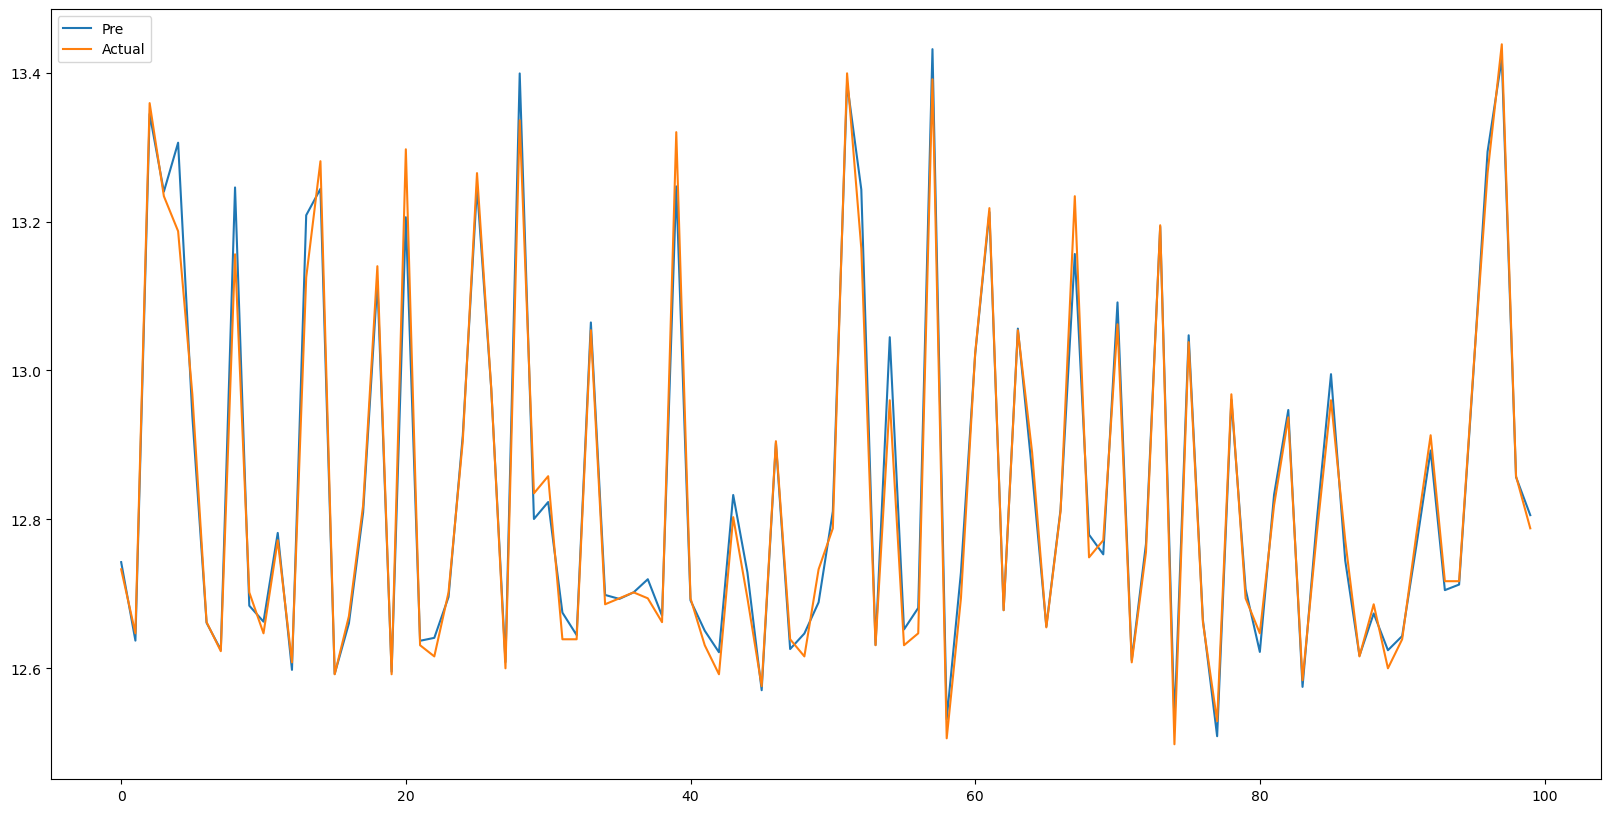

In [8]:
from sklearn.metrics import mean_absolute_error as mae
def plot_predictions1(model, X, y_scaled, start=0, end=100):
    y_pred_scaled = model.predict(X).flatten()
    predictions = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y = scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.figure(figsize=(20,10))
    plt.plot(df['Predictions'][start:end], label = 'Pre')
    plt.plot(df['Actuals'][start:end], label = 'Actual')
    plt.legend()
    return df, mae(y, predictions)
plot_predictions1(model1, X_state_te, y_state_te)

In [10]:
import joblib
from tensorflow.keras.models import model_from_json
model_json = model1.to_json()
with open("model2_0.json", "w") as json_file:
    json_file.write(model_json)
model1.save_weights("model2_0_weights.h5")

# Lưu siêu tham số và các thông tin khác bằng joblib
model_info = {
    "model2_0_json_path": "model2_0.json",
    "model2_0_weights_path": "model2_0_weights.h5",
    "optimizer": {
        "name": "Adam",
        "learning_rate": 0.001
    },
    "loss": 'mae'
}
joblib.dump(model_info, 'model2_0_info.pkl')

['model2_0_info.pkl']

In [12]:
model1.save('model2_0.h5')

C:\Users\ainzo\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
